<a href="https://colab.research.google.com/github/sirisinahal/Image-Classification/blob/main/TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/contents/drive')

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [ ]:
data_dir = 'C://Users//ADMIN//Downloads//Cat_Dog_data'

# TODO: Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '//train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '//test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

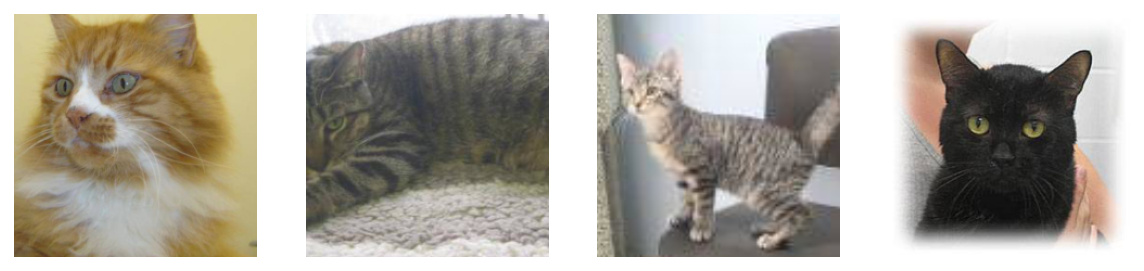

In [ ]:
# change this to the trainloader or testloader 
data_iter = iter(testloader)

images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    helper.imshow(images[ii], ax=ax, normalize=False)

In [ ]:
model = models.densenet121(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\ADMIN/.cache\torch\hub\checkpoints\densenet121-a639ec97.pth


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.densenet121(pretrained=True)

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False
    
model.classifier = nn.Sequential(nn.Linear(1024, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(256, 2),
                                 nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)

model.to(device);

In [ ]:
epochs = 1
steps = 0
running_loss = 0
print_every = 5
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()

Epoch 1/1.. Train loss: 0.662.. Test loss: 0.109.. Test accuracy: 0.975
Epoch 1/1.. Train loss: 0.389.. Test loss: 0.182.. Test accuracy: 0.918
Epoch 1/1.. Train loss: 0.255.. Test loss: 0.088.. Test accuracy: 0.969
Epoch 1/1.. Train loss: 0.253.. Test loss: 0.086.. Test accuracy: 0.970
Epoch 1/1.. Train loss: 0.199.. Test loss: 0.114.. Test accuracy: 0.955
Epoch 1/1.. Train loss: 0.217.. Test loss: 0.058.. Test accuracy: 0.982
Epoch 1/1.. Train loss: 0.220.. Test loss: 0.059.. Test accuracy: 0.978
Epoch 1/1.. Train loss: 0.181.. Test loss: 0.051.. Test accuracy: 0.983
Epoch 1/1.. Train loss: 0.239.. Test loss: 0.059.. Test accuracy: 0.979
Epoch 1/1.. Train loss: 0.218.. Test loss: 0.056.. Test accuracy: 0.979
Epoch 1/1.. Train loss: 0.158.. Test loss: 0.067.. Test accuracy: 0.980
Epoch 1/1.. Train loss: 0.167.. Test loss: 0.071.. Test accuracy: 0.973
Epoch 1/1.. Train loss: 0.163.. Test loss: 0.048.. Test accuracy: 0.984


KeyboardInterrupt: 